# KNN算法实现

# 读取数据 image label

In [1]:
from numpy import *
import operator
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from os import listdir
from mpl_toolkits.mplot3d import Axes3D
import struct

#读取图片
def read_image(file_name):
    #先用二进制方式把文件都读进来
    file_handle=open(file_name,"rb")  #以二进制打开文档
    file_content=file_handle.read()   #读取到缓冲区中

    offset=0
    head = struct.unpack_from('>IIII', file_content, offset)  # 取前4个整数，返回一个元组
    offset += struct.calcsize('>IIII')
    imgNum = head[1]  #图片数
    rows = head[2]   #宽度
    cols = head[3]  #高度
    # print(imgNum)
    # print(rows)
    # print(cols)

    #测试读取一个图片是否读取成功
    #im = struct.unpack_from('>784B', file_content, offset)
    #offset += struct.calcsize('>784B')

    images=np.empty((imgNum , 784))#empty，是它所常见的数组内的所有元素均为空，没有实际意义，它是创建数组最快的方法
    image_size=rows*cols#单个图片的大小
    fmt='>' + str(image_size) + 'B'#单个图片的format

    for i in range(imgNum):
        images[i] = np.array(struct.unpack_from(fmt, file_content, offset))
        # images[i] = np.array(struct.unpack_from(fmt, file_content, offset)).reshape((rows, cols))
        offset += struct.calcsize(fmt)

    return images

    '''bits = imgNum * rows * cols  # data一共有60000*28*28个像素值
    bitsString = '>' + str(bits) + 'B'  # fmt格式：'>47040000B'
    imgs = struct.unpack_from(bitsString, file_content, offset)  # 取data数据，返回一个元组
    imgs_array=np.array(imgs).reshape((imgNum,rows*cols))     #最后将读取的数据reshape成 【图片数，图片像素】二维数组
    return imgs_array'''

def read_label(file_name):
    file_handle = open(file_name, "rb")  # 以二进制打开文档
    file_content = file_handle.read()  # 读取到缓冲区中

    head = struct.unpack_from('>II', file_content, 0)  # 取前2个整数，返回一个元组
    offset = struct.calcsize('>II')

    labelNum = head[1]  # label数
    # print(labelNum)
    bitsString = '>' + str(labelNum) + 'B'  # fmt格式：'>47040000B'
    label = struct.unpack_from(bitsString, file_content, offset)  # 取data数据，返回一个元组
    return np.array(label)

# KNN Train

In [2]:
# KNN算法
def KNN(test_data, images, labels, k):
    # images.shape[0]表示的是读取矩阵第一维度的长度，代表行数60k
    dataSetSize = images.shape[0]  # 60k
    # tile函数在行上重复dataSetSize次，在列上重复1次
    # 将test_data乘60k。再reshape成784行*60000列
    distance1 = tile(test_data, (dataSetSize)).reshape((dataSetSize,784))-images
    # 每个元素平方
    distance2 = distance1**2
    # 矩阵每行相加
    distance3 = distance2.sum(axis=1) # 合并成一行
    # 开方
    distances4 = distance3**0.5
    # 欧氏距离计算结束
    # 返回从小到大排序的索引
    sortedDistIndicies = distances4.argsort()
    classCount=np.zeros((10), np.int32) #10是代表10个类别
    for i in range(k): # 统计排在前k名的预测结果
        ## 找到图片对应的数据
        voteIlabel = labels[sortedDistIndicies[i]] 
        ## 把这个Count + 1
        classCount[voteIlabel] += 1

    return np.argmax(classCount),sortedDistIndicies[0:k]

# KNN TEST（用于绘制misclassification rate）

In [3]:
def KNN_TEST(train_x,test_x,train_y,test_y,k):    
    testNum = test_x.shape[0]
    print('测试图片数量:',testNum)
    errorCount = 0  # 判断错误的个数
    #error = []
    #error_image = []
    errorCount = 0  # 判断错误的个数
    for i in range(testNum):
        result,sortlist = KNN(test_x[i], train_x, train_y, k)
        # print('返回的结果是: %s, 真实结果是: %s' % (result, test_y[i]))
        if result != test_y[i]:
            errorCount += 1.0 # 如果mnist验证集的标签和本身标签不一样，则出错
            ##print('返回的结果是: %s, 真实结果是: %s' % (result, test_y[i]))
            ## 为了更加直观，只打印出错误的预测结果
            #error.append(test_y[i])
            #error_image.append(sortlist)
    error_rate = errorCount / float(testNum)  # 计算出错率
    acc = 1.0 - error_rate
    #print("\n正确预测率: %f" % (acc))
    #print("\n错误预测率: %f" % (error_rate))
    #print("\n错误预测的图片数量: %d" % errorCount)
    #return error,error_image
    return error_rate

# KNN TEST(传入单张图片，输出K个最相似的图片)

In [4]:
def KNN_TEST_PRINT(train_x,test_x,train_y,test_y,test_id,k):
    result,sortlist = KNN(test_x[test_id], train_x, train_y, k)
    print('预测结果为:',result,'实际结果为:',test_y[test_id])
    #sortlist.append(test_id)
    ## 打印图片
    fig=plt.figure(figsize=(8,8))
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0.05,wspace=0.05)
    for i in range(len(sortlist)):
        images = np.reshape(train_x[sortlist[i]], [28,28])
        ax=fig.add_subplot(6,5,i+1,xticks=[],yticks=[])
        ax.imshow(images,cmap=plt.cm.binary,interpolation='nearest')
        ax.text(0,7,str(train_y[sortlist[i]]))
    plt.show()
    plt.pause(5)##停留5秒
    plt.close(fig)##关闭图片

# 传入数据

In [5]:
train_image = "MNIST/train-images-idx3-ubyte"
test_image = "MNIST/t10k-images-idx3-ubyte"
train_label = "MNIST/train-labels-idx1-ubyte"
test_label = "MNIST/t10k-labels-idx1-ubyte"
# 读取数据
train_x = read_image(train_image)  # train_image
test_x = read_image(test_image)  # test_image
train_y = read_label(train_label)  # train_label
test_y = read_label(test_label)  # test_label

# 设置运行参数

In [6]:
# 训练图片数
trainNum = 6000
# 测试图片数
testNum = 100
# 距离最小的k个图片
k = 30

train_Start = random.randint(0,60001-trainNum)
train_End = train_Start+trainNum
train_i = train_x[train_Start:train_End,:]
train_l = train_y[train_Start:train_End]

test_Start = random.randint(0,10001-testNum)
## test_Start = 0
test_End = test_Start+testNum
test_i = test_x[test_Start:test_End,:]
test_l = test_y[test_Start:test_End]

# 运行

预测结果为: 2 实际结果为: 2


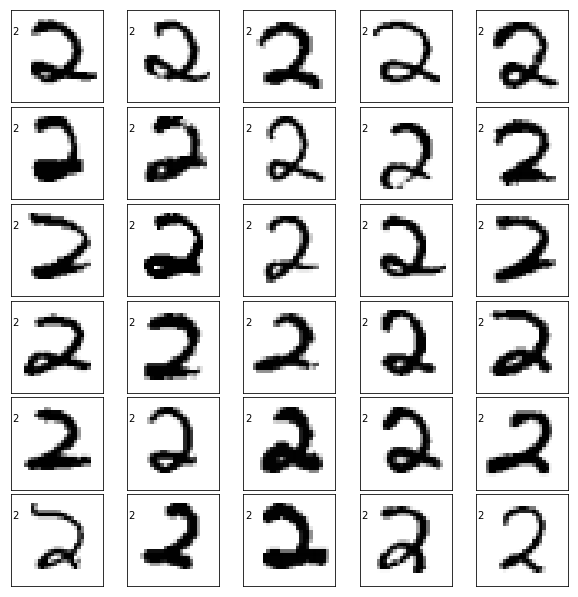

In [18]:
## 打印输入图片的k近邻图片
import matplotlib
matplotlib.use('TkAgg') ##macOS需要换一下后端才能显示图片。
from matplotlib import pyplot as plt
%matplotlib inline
## 输入图片的编号（随机产生）
test_id = random.randint(0,10000)
KNN_TEST_PRINT(train_i,test_x,train_l,test_y,test_id,k)


No. 1
训练集图片数量： 6000 区间: 16134 ~ 22134
测试集图片数量： 500 区间: 6339 ~ 6839
测试图片数量: 500
K= 1 accuracy: 0.954

No. 2
训练集图片数量： 6000 区间: 46909 ~ 52909
测试集图片数量： 500 区间: 4644 ~ 5144
测试图片数量: 500
K= 2 accuracy: 0.918

No. 3
训练集图片数量： 6000 区间: 15113 ~ 21113
测试集图片数量： 500 区间: 8248 ~ 8748
测试图片数量: 500
K= 3 accuracy: 0.97

No. 4
训练集图片数量： 6000 区间: 2391 ~ 8391
测试集图片数量： 500 区间: 1526 ~ 2026
测试图片数量: 500
K= 4 accuracy: 0.902

No. 5
训练集图片数量： 6000 区间: 23966 ~ 29966
测试集图片数量： 500 区间: 8799 ~ 9299
测试图片数量: 500
K= 5 accuracy: 0.972

No. 6
训练集图片数量： 6000 区间: 5724 ~ 11724
测试集图片数量： 500 区间: 2465 ~ 2965
测试图片数量: 500
K= 6 accuracy: 0.9339999999999999

No. 7
训练集图片数量： 6000 区间: 14115 ~ 20115
测试集图片数量： 500 区间: 4924 ~ 5424
测试图片数量: 500
K= 7 accuracy: 0.978

No. 8
训练集图片数量： 6000 区间: 920 ~ 6920
测试集图片数量： 500 区间: 7532 ~ 8032
测试图片数量: 500
K= 8 accuracy: 0.968

No. 9
训练集图片数量： 6000 区间: 9407 ~ 15407
测试集图片数量： 500 区间: 239 ~ 739
测试图片数量: 500
K= 9 accuracy: 0.882


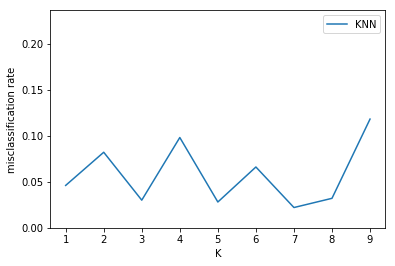

In [21]:
## 打印misclassification rate曲线
#import datetime
#start = datetime.datetime.now()
import matplotlib
matplotlib.use('TkAgg') ##macOS需要换一下后端才能显示图片
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

# 训练图片数
trainNum = 6000
# 测试图片数
testNum = 500

x = np.arange(1, 10, 1)
y = []
for t in x:
    ##数据选择
    train_Start = random.randint(0,60001-trainNum)
    train_End = train_Start+trainNum
    train_i = train_x[train_Start:train_End,:]
    train_l = train_y[train_Start:train_End]

    test_Start = random.randint(0,10001-testNum)
    ## test_Start = 0
    test_End = test_Start+testNum
    test_i = test_x[test_Start:test_End,:]
    test_l = test_y[test_Start:test_End]
    
    print('\nNo.',t)
    
    print('训练集图片数量：',train_i.shape[0],'区间:',train_Start,'~',train_End)
    print('测试集图片数量：',test_i.shape[0],'区间:',test_Start,'~',test_End)
    
    misclassification_rate = KNN_TEST(train_i,test_i,train_l,test_l,t)
    print('K=',t,'accuracy:',1-misclassification_rate)
    y.append(misclassification_rate)
plt.plot(x, y, label='KNN')
plt.xlabel("K")
plt.ylabel("misclassification rate")
plt.ylim(0,2*max(y))
plt.legend()
plt.show()
#error,error_image=KNN_TEST(train_i,test_i,train_l,test_l,k)
#b=[i+testNum for i in error]

#for i in range(len(b)):
#    print(error[i],error_image[i])

#end = datetime.datetime.now()
#print ('程序运行时间:',end-start)